# ***Causal Learning Tutorial - Handwritten English Characters and Digits***

Author:
        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.


<p align="center">
  <img src="https://github.com/user-attachments/assets/d82b8b25-c9bf-459b-9208-3359e5339b5e" alt="IMG" width='800'>
</p>

Source: https://www.kaggle.com/datasets/sujaymann/handwritten-english-characters-and-digits/data

<a id="1"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'>1.</b> Import Necessary Libraries </b></h1>

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

path_append = "../../" # Go up one directory from where you are.
sys.path.append(path_append) 

import torch
from tools.config.ml_config import MLConfig
from tools.config.data_config import DataConfig
from nn.utils.init_layer import set_random_seed
set_random_seed(0)

<a id="2"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>2.</b> Data Preprocess </b></h1>

In [2]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

n_img_sz = 224 

transform = transforms.Compose([
    transforms.Resize((n_img_sz, n_img_sz)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  
])

trainset = ImageFolder(root=path_append + '../data/Handwritten English Characters and Digits/handwritten-english-characters-and-digits/combined_folder/train', transform=transform)
testset = ImageFolder(root=path_append + '../data/Handwritten English Characters and Digits/handwritten-english-characters-and-digits/combined_folder/test', transform=transform)

In [3]:
def normalize_label(label):
    if '_caps' in label:
        return label.replace('_caps', '').lower()
    else:
        return label.lower()

def transform_label(label):
    if label.isdigit():
        return int(label)
    else:
        return ord(label) - ord('a') + 10

grouped_classes = [normalize_label(label) for label in trainset.classes]
grouped_classes = [transform_label(label) for label in grouped_classes]

unique_grouped_classes = sorted(set(grouped_classes))

print("Unique Grouped Classes:", unique_grouped_classes)

for idx, (_, label) in enumerate(trainset.samples):
    original_label = trainset.classes[label]
    normalized_label = normalize_label(original_label)
    new_label = transform_label(normalized_label)  
    trainset.samples[idx] = (trainset.samples[idx][0], new_label)

for idx, (_, label) in enumerate(testset.samples):
    original_label = testset.classes[label]
    normalized_label = normalize_label(original_label)
    new_label = transform_label(normalized_label)  
    testset.samples[idx] = (testset.samples[idx][0], new_label) 


num_classes = len(unique_grouped_classes)

Unique Grouped Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [4]:
# Custom dataset class for CelebA dataset
class HandWrittenEng(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        X, y = self.dataset[index]  # Get the image and label at the specified index

        # Ensure y is an integer and within the expected range
        y = torch.tensor(y, dtype=torch.long).unsqueeze(0)
        return X, y  # Return the image and the one-hot encoded label
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
        
trainset = HandWrittenEng(trainset)
testset = HandWrittenEng(testset)

<a id="3"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #427bf5'>3.</b> Modeling</b></h1>

In [5]:
from causal_learning import CausalLearning

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

data_config = DataConfig(dataset_name = 'hand_written_eng', task_type='multi_class_classification', obs_shape=[1, 224, 224], label_size=num_classes, 
                         explain_size = 16, show_image_indices=[560, 563, 1048, 633, 1284, 1275])

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_config = MLConfig(model_name = 'resnet18')

ml_config.training.num_epochs = 50
ml_config.model.num_layers = 4
ml_config.optimization.learning_rate = 2e-4
ml_config.training.error_function = 'mae'

# Initialize the CausalLearning class with the training configuration, data configuration, device, and use_print and use_wandb flags
causal_learning = CausalLearning(ml_config, data_config, device, use_print=True, use_wandb=False)


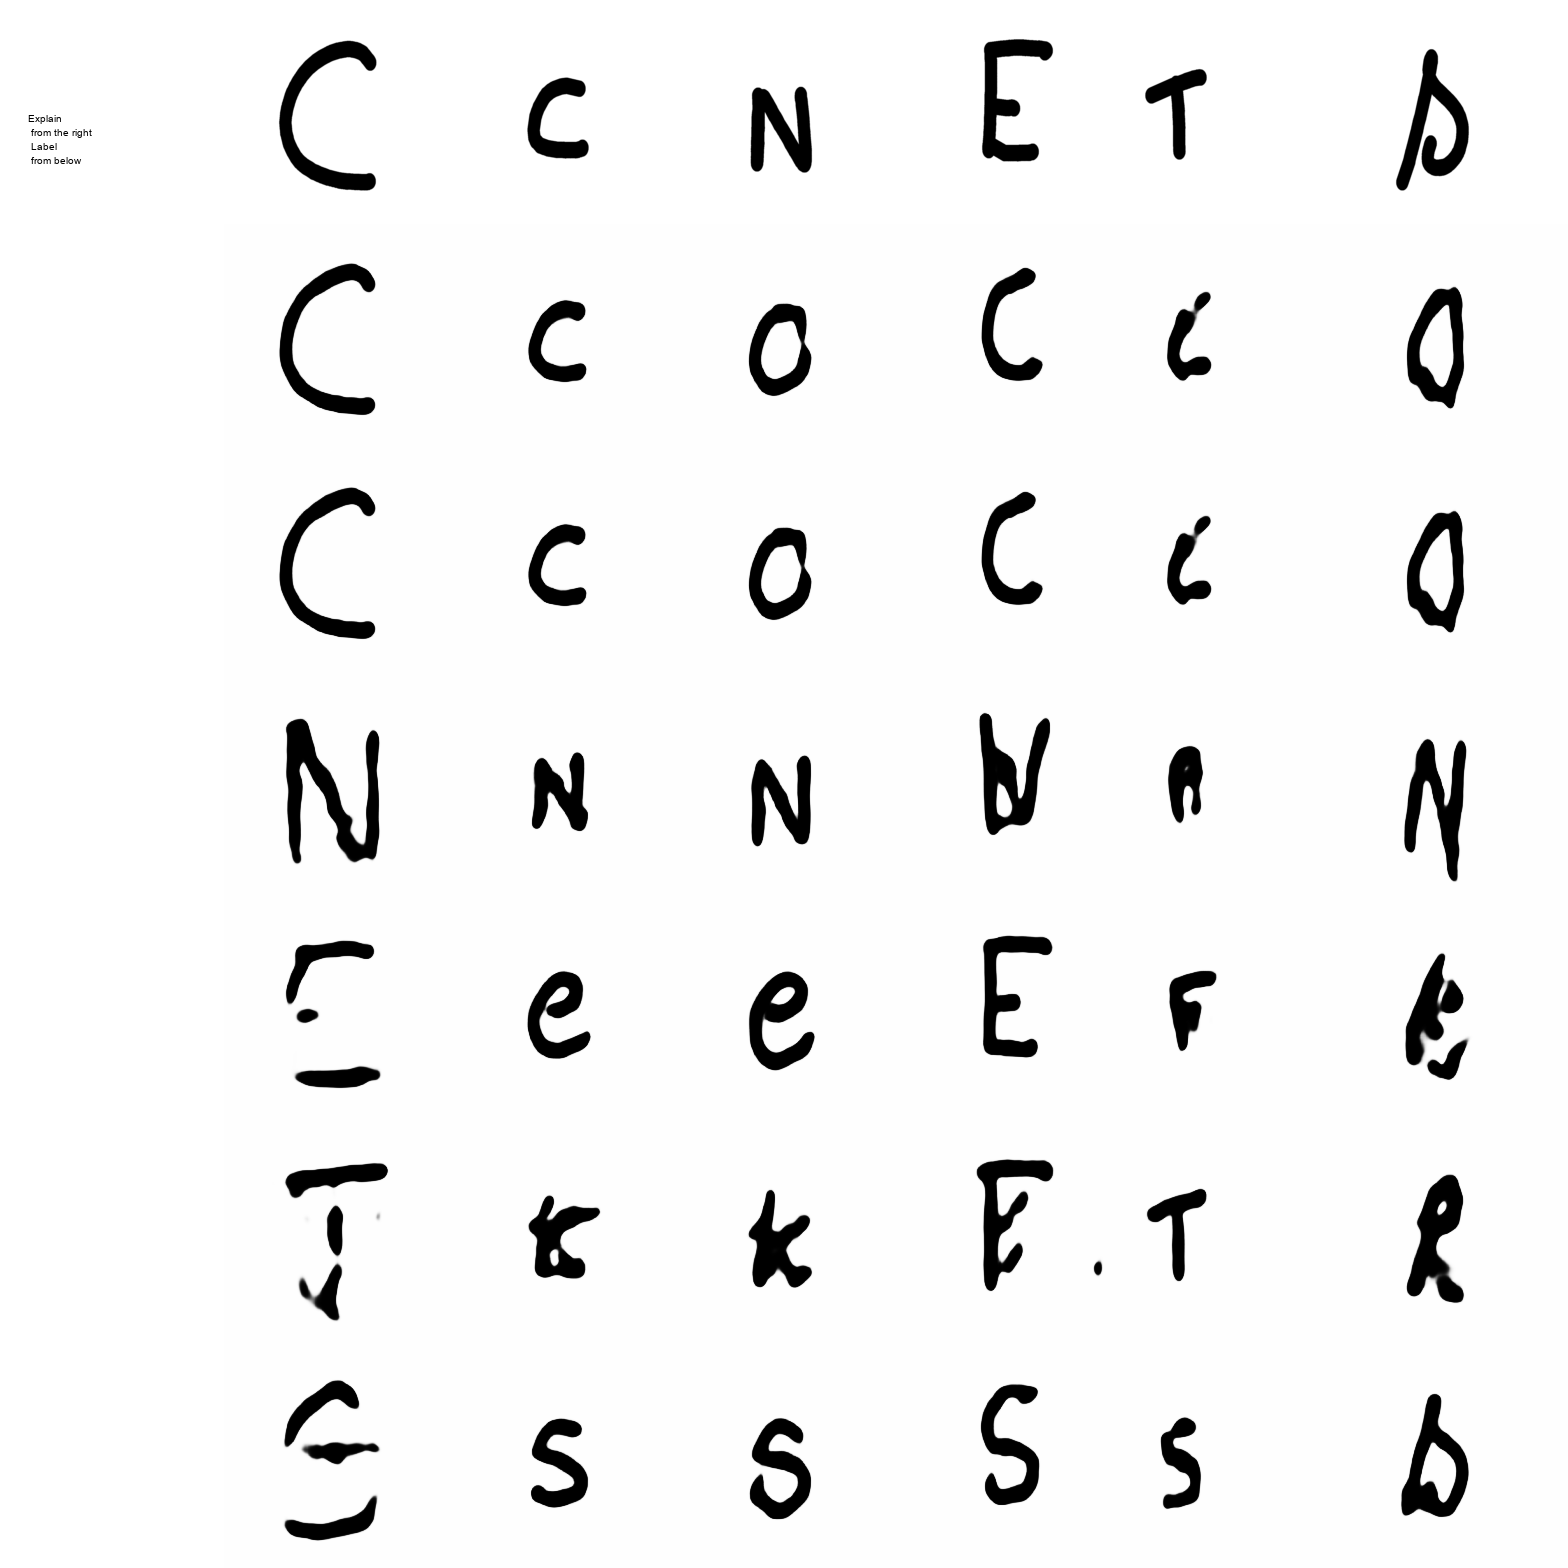

[98/100][34/42][Time 55.91]
Unified LR across all optimizers: 0.00017661363964545368
=====================Train Metrics=======================
CCNet:  Three Resnet18
Inf: 0.0051	Gen: 0.0207	Rec: 0.0213	E: 0.0045	R: 0.0058	P: 0.0368

accuracy: 0.8281
precision: 0.1356
recall: 0.1389
f1_score: 0.1371

=====================Eval Metrics========================
accuracy: 0.8008
precision: 0.4941
recall: 0.5177
f1_score: 0.5000



Iterations:   0%|          | 0/42 [00:00<?, ?it/s]

In [6]:
causal_learning.train(trainset, testset)

<a id="4"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #427bf5'>4.</b> Testing</b></h1>

torch.Size([1, 1, 224, 224])


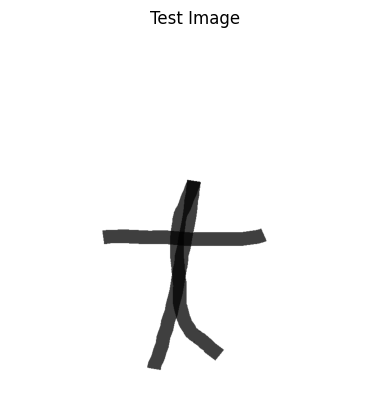

In [56]:
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((n_img_sz, n_img_sz)),  # Resize the image to the specified size
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the tensor
])

# Specify the image file path
image_path = '../../t.png'

# Load the image
image = Image.open(image_path)

# Apply the transformation and convert the image to a tensor
test_png = transform(image)

# Add a batch dimension (1, C, H, W) to make it ready for model input
test_png = test_png.unsqueeze(0)

# Move the tensor to the appropriate device
test_png = test_png.to(device)

# Print the shape of the tensor
print(test_png.shape)

# Display the original image
plt.imshow(image)
plt.title("Test Image")
plt.axis('off')  # Hide the axes
plt.show()


In [57]:
# Run inference on the test image using the causal learning model
test_output = causal_learning.ccnet.infer(test_png)

# Find the class index with the highest probability
_, predicted_class = torch.max(test_output, 1)

# Convert the predicted class index to a Python integer
predicted_class = predicted_class.item()

# Print the predicted class index
print(f"Predicted Class Index: {predicted_class}")

# Define the class mapping
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
           'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
           'u', 'v', 'w', 'x', 'y', 'z']

# Find the label corresponding to the predicted class index
predicted_label = classes[predicted_class]

# Print the predicted label in the original label set
print(f"Predicted Label in Original Label: {predicted_label}")


Predicted Class Index: 29
Predicted Label in Original Label: t
